In [1]:
# Full end-to-end script for your dataset: /mnt/data/customer_churn.csv
# Requirements: pandas, numpy, scikit-learn, xgboost, shap, matplotlib
# In Colab: !pip install xgboost shap

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "/content/customer_churn.csv"

In [3]:
from google.colab import files
uploaded = files.upload()   # upload customer_churn.csv

df = pd.read_csv("customer_churn.csv")
df.head()


Saving customer_churn.csv to customer_churn.csv


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn
0,Male,1,Yes,No,6,No,DSL,97.95,3501.24,No
1,Female,0,No,No,34,No,No,21.62,5273.29,No
2,Male,0,No,No,54,Yes,No,101.84,3512.98,No
3,Male,0,No,No,13,No,No,24.01,2228.50,No
4,Male,0,No,Yes,9,No,No,108.99,4474.21,No


In [9]:
!pip install xgboost shap pandas numpy scikit-learn matplotlib seaborn

In [4]:
#Clean target and numeric columns (important)

#Make sure Churn is 0/1 and TotalCharges is numeric (common error):
# Standardize churn to 0/1
df['Churn'] = df['Churn'].astype(str).str.strip().str.lower().map({'yes':1,'no':0})
# Convert TotalCharges to numeric (many datasets have spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill or drop rows with missing TotalCharges (choose one)
df = df.dropna(subset=['TotalCharges'])   # simplest
# OR: df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

print(df['Churn'].value_counts())
df.info()


Churn
0    720
1    280
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           1000 non-null   object 
 1   SeniorCitizen    1000 non-null   int64  
 2   Partner          1000 non-null   object 
 3   Dependents       1000 non-null   object 
 4   tenure           1000 non-null   int64  
 5   PhoneService     1000 non-null   object 
 6   InternetService  1000 non-null   object 
 7   MonthlyCharges   1000 non-null   float64
 8   TotalCharges     1000 non-null   float64
 9   Churn            1000 non-null   int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 78.3+ KB


In [19]:
#STEP 2 — Identify Categorical & Numerical Columns
TARGET = "Churn"

cat_cols = df.select_dtypes(include=["object", "category","bool"]).columns.tolist()
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()

if TARGET in cat_cols: cat_cols.remove(TARGET)
if TARGET in num_cols: num_cols.remove(TARGET)

cat_cols, num_cols


(['gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'])

In [5]:
#Select features, identify categorical & numeric lists
TARGET = "Churn"
all_cols = df.columns.tolist()
# drop customerID if exists
if 'customerID' in all_cols:
    df = df.drop(columns=['customerID'])

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
if TARGET in cat_cols: cat_cols.remove(TARGET)
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if TARGET in num_cols: num_cols.remove(TARGET)

print("Categorical:", cat_cols)
print("Numerical:", num_cols)


Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService']
Numerical: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [6]:
#Train/test split (use stratify)
from sklearn.model_selection import train_test_split

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape, y_train.value_counts(normalize=True)


((800, 9),
 (200, 9),
 Churn
 0    0.72
 1    0.28
 Name: proportion, dtype: float64)

In [11]:
print("df columns =", df.columns.tolist())
print("num_cols =", num_cols)
print("cat_cols =", cat_cols)

# Check invalid columns
print("\nInvalid numeric columns:", [c for c in num_cols if c not in df.columns])
print("Invalid categorical columns:", [c for c in cat_cols if c not in df.columns])


df columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'InternetService', 'MonthlyCharges', 'TotalCharges', 'Churn']
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService']

Invalid numeric columns: []
Invalid categorical columns: []


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')


In [13]:
#Train XGBoost Model
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    eval_metric="logloss",
    random_state=42
)

pipe = make_pipeline(preprocessor, model)

pipe.fit(X_train, y_train)
print("Model training completed.")



Model training completed.


In [25]:
# Evaluate Model Performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.65
Precision: 0.23076923076923078
Recall: 0.10714285714285714
F1 Score: 0.14634146341463414

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.86      0.78       144
           1       0.23      0.11      0.15        56

    accuracy                           0.65       200
   macro avg       0.47      0.48      0.46       200
weighted avg       0.58      0.65      0.60       200



In [17]:
#prepare data for shap
# Extract final trained model inside pipeline
trained_model = pipe.named_steps['xgbclassifier']

# Transform data for SHAP
X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

print("Transformed shapes:", X_train_p.shape, X_test_p.shape)



Transformed shapes: (800, 15) (200, 15)


In [18]:
# get feature names
# Get feature names after OneHotEncoding
ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
cat_features = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + cat_features

print("Number of features:", len(feature_names))


Number of features: 15


In [19]:
# shap initialization
import shap
import matplotlib.pyplot as plt
import os

os.makedirs("plots", exist_ok=True)

explainer = shap.TreeExplainer(trained_model)
shap_values = explainer.shap_values(X_train_p)

print("SHAP values shape:", shap_values.shape)


SHAP values shape: (800, 15)


In [29]:
import shap
shap.initjs()

# Prepare transformed data
X_train_trans = model_pipeline.named_steps["preprocessor"].transform(X_train)
X_test_trans = model_pipeline.named_steps["preprocessor"].transform(X_test)

# Extract trained XGBoost model
trained_xgb = model_pipeline.named_steps["classifier"]

# SHAP Explainer
explainer = shap.TreeExplainer(trained_xgb)
shap_values = explainer.shap_values(X_test_trans)


In [21]:
#sHAP plots
#SHAP Global Summary Plot
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_train_p, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig("plots/shap_summary.png", dpi=200)
plt.close()



In [22]:
#SHAP Bar Plot (Feature Importance)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_train_p, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("plots/shap_bar.png", dpi=200)
plt.close()


In [23]:
#decision plot
plt.figure(figsize=(10,6))
shap.decision_plot(explainer.expected_value, shap_values[:200], feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig("plots/shap_decision.png", dpi=200)
plt.close()


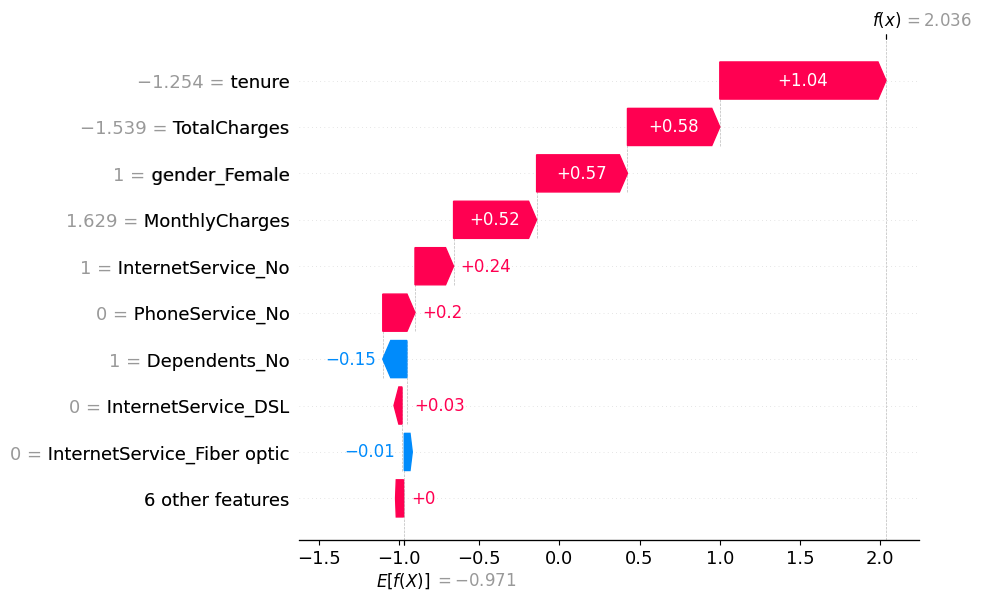

In [24]:
#One Customer Waterfall Plot
# choose the highest-churn predicted customer
high_idx = y_proba.argmax()

sample = X_test.iloc[[high_idx]]
sample_p = preprocessor.transform(sample)

shap_values_sample = explainer.shap_values(sample_p)[0]

plt.figure(figsize=(9,7))
shap.plots.waterfall(
    shap.Explanation(values=shap_values_sample,
                     base_values=explainer.expected_value,
                     data=sample_p[0],
                     feature_names=feature_names)
)
plt.savefig("plots/shap_waterfall.png", dpi=200, bbox_inches='tight')
plt.close()



In [29]:
import os
os.makedirs("plots", exist_ok=True)

plt.savefig("plots/shap_force_or_waterfall.png", dpi=200, bbox_inches='tight')
plt.close()

In [30]:
import os
os.makedirs("/content/plots", exist_ok=True)
print("Folder Created:", os.path.exists("/content/plots"))

Folder Created: True


In [32]:
import joblib
joblib.dump(model, "model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']

In [33]:
with open("requirements.txt","w") as f:
    f.write("pandas\nnumpy\nscikit-learn\nxgboost\nshap\nmatplotlib\nseaborn\n")

In [36]:
%%writefile requirements.txt
pandas
numpy
scikit-learn
xgboost
shap
matplotlib
seaborn

Overwriting requirements.txt
